In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%autoreload

In [3]:
import torch
import optuna
import os
import numpy as np
import pandas as pd
import deepdish as dd
import torch.nn as nn
import pytorch_lightning as pl

from torch.nn import functional as F
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc, matthews_corrcoef, make_scorer

In [26]:
def get_scaled_abl(ft):
    unpack = list((*ft,))
    tr_selection = train_features[unpack].values
    vl_selection = val_features[unpack].values
    ts_selection = test_features[unpack].values
    scaler = MinMaxScaler()
    scaler = scaler.fit(np.concatenate((tr_selection, vl_selection, ts_selection), axis=0))
    return scaler.transform(tr_selection), scaler.transform(vl_selection), scaler.transform(ts_selection), unpack

In [20]:
def report(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax = plt.subplot()
    sns.heatmap(cmn, annot=True, fmt=".4f", ax=ax)

    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(["Low", "High"])
    ax.yaxis.set_ticklabels(["Low", "HIgh"])
    for text in ax.texts:
        text.set_size(13)
    plt.show()

    stats = precision_recall_fscore_support(y_test, y_pred, average=None)
    mcc = matthews_corrcoef(y_test, y_pred)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    print("Precision: %.4f  %.4f" % tuple(stats[0]))
    print("Recall: %.4f  %.4f"  % tuple(stats[1]))
    print("F1-Score %.4f  %.4f"  % tuple(stats[2]))
    print("MCC %.4f" % mcc)
    print("AUROC %.4f" % roc_auc)

In [4]:
train = dd.io.load('../../splits/train.h5')
val = dd.io.load('../../splits/val.h5')
test = dd.io.load('../../splits/test.h5')
y_train = np.load('../../splits/y_train.npy')
y_val = np.load('../../splits/y_val.npy')
y_test = np.load('../../splits/y_test.npy')

In [5]:
y_train = y_train * 100
y_val = y_val * 100
y_test = y_test * 100

In [6]:
df_feat = pd.read_csv('../../datasets/dataset_extracted_features.csv')

In [7]:
df_feat

,Seq1,Seq2,Aln,GC1,GC2,SingleCon1,SingleCon2,PairCon1,PairCon2,SingleMFE1,SingleMFE2,Yield,Label
0,AGTACAAGTAGGACAGGAAGATA,TATCTTCCTGTCCTACTCGTACT,106,39.130435,43.478261,0.999957,0.999974,0.000022,0.000013,0.000000,0.000000,0.974025,1
1,GAGTTCCGGTTGCCTTTCA,GAGTTCCGGGTGCCTTTCA,12,52.631579,57.894737,0.999844,0.999739,0.000078,0.000130,0.000000,0.000000,0.000193,0
2,TCTGGAACTAGTGCAATTTAGC,TCTAAATTGCACTAGTTCCAGA,101,40.909091,36.363636,0.999556,0.999598,0.000222,0.000201,0.000000,0.000000,0.991153,1
3,GGCGCGCGACGCGACATCCGATAAGA,TCTTATCGGATCTCGCGTCGCGCGCC,121,65.384615,65.384615,0.999455,0.999183,0.000273,0.000408,-2.595847,-1.870977,0.999227,1
4,GTGTACCATACCATGAACGCCGGA,TCCGGCGTCATGGTATGGTACAC,110,54.166667,56.521739,0.998893,0.999652,0.000554,0.000174,0.000000,0.000000,0.996585,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556971,AGCAAGGCACAGGACTTAGTACCAAA,TTTGGTACTAAGTCCTGTGCCGCT,113,46.153846,50.000000,0.999938,0.999916,0.000031,0.000042,-0.317577,0.000000,0.995240,1
2556972,CAGGCTGAGACCTAACTCTTTAGCC,GGCTAAAAGGTTAGGTCTCAGCCTG,110,52.000000,52.000000,0.999786,0.999896,0.000107,0.000052,0.000000,0.000000,0.973733,1
2556973,CATATCAACTCCAGGAATCCTT,AAGGATTCCTGCAGATGATATG,92,40.909091,40.909091,0.999334,0.998677,0.000333,0.000662,0.000000,0.000000,0.529762,1
2556974,GAATGCAGAGTTCGATGTCGGT,ACCAGTACACATCGAACTCTGCATTC,96,50.000000,46.153846,0.999855,0.999893,0.000073,0.000053,0.000000,0.000000,0.984665,1


In [8]:
train_features = df_feat.loc[(df_feat['Seq1'].isin([item[0] for item in train])) & (df_feat['Seq2'].isin([item[1] for item in train]))]
val_features = df_feat.loc[(df_feat['Seq1'].isin([item[0] for item in val])) & (df_feat['Seq2'].isin([item[1] for item in val]))]
test_features = df_feat.loc[(df_feat['Seq1'].isin([item[0] for item in test])) & (df_feat['Seq2'].isin([item[1] for item in test]))]

In [10]:
train_feat = train_features[['Aln', 'GC1', 'GC2', 'SingleCon1', 'SingleCon2', 'PairCon1', 'PairCon2', 'SingleMFE1', 'SingleMFE2']].values
val_feat = val_features[['Aln', 'GC1', 'GC2', 'SingleCon1', 'SingleCon2', 'PairCon1', 'PairCon2', 'SingleMFE1', 'SingleMFE2']].values
test_feat = test_features[['Aln', 'GC1', 'GC2', 'SingleCon1', 'SingleCon2', 'PairCon1', 'PairCon2', 'SingleMFE1', 'SingleMFE2']].values

In [11]:
train_labels = train_features[['Label']].values.squeeze()
val_labels = val_features[['Label']].values.squeeze()
test_labels = test_features[['Label']].values.squeeze()

In [12]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.concatenate((train_feat, val_feat, test_feat), axis=0))
scaled_train = scaler.transform(train_feat)
scaled_val = scaler.transform(val_feat)
scaled_test = scaler.transform(test_feat)

In [13]:
torch.set_default_tensor_type(torch.FloatTensor)
torch.set_default_dtype(torch.float)

In [47]:
class LightningWrapper(pl.LightningModule):
    def __init__(self, num_batches=1024, lr=0.00021889729263244634, dropout=0.32964090436497967):
        super(LightningWrapper, self).__init__()
        
        def lin_block(in_dim, out_dim, dropout):
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
            )
        
        self.num_batches = num_batches
        self.lr = lr
        self.dropout = dropout
        
        self.lin = nn.Sequential(
            lin_block(5, 117, self.dropout),
            lin_block(117, 18, self.dropout),
            lin_block(18, 7, self.dropout),
            lin_block(7, 19, self.dropout),
            lin_block(19, 1, self.dropout),
        )
        
        self.out_predictions = []
        self.save_hyperparameters()

    def forward(self, x):
        return self.lin(x.float()).squeeze()

    def training_step(self, batch, batch_nb):
        x, target = batch
        output = self.forward(x)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_nb):
        x, target = batch
        output = self.forward(x)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        
        self.log("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_nb):
        x, target = batch
        output = self.forward(x)
        self.out_predictions.append(output)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        
        self.log("test_loss", loss) 
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self.lr)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            list(zip(tr, train_labels)),
            batch_size=self.num_batches,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            list(zip(vl, val_labels)),
            batch_size=self.num_batches,
            shuffle=False,
        )
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            list(zip(ts, test_labels)),
            batch_size=self.num_batches,
            shuffle=False,
        )

In [18]:
early_stopping = EarlyStopping('val_loss', patience=3)

trainer = pl.Trainer(
    gpus=[0],
    callbacks=[early_stopping],
    min_epochs=3
)

model = LightningWrapper()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [19]:
trainer.fit(model)


  | Name | Type       | Params
------------------------------------
0 | lin  | Sequential | 3.6 K 
------------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [21]:
trainer.test()

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.3980, device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_loss': 0.3980419337749481}]

In [22]:
predictions = torch.sigmoid(torch.cat(model.out_predictions))
predictions = torch.gt(predictions, 0.5).int()

In [23]:
predictions.shape

torch.Size([255701])

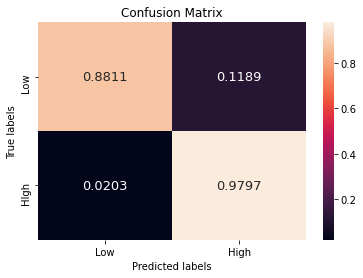

Precision: 0.9713  0.9137
Recall: 0.8811  0.9797
F1-Score 0.9240  0.9455
MCC 0.8728
AUROC 0.9304


In [24]:
report(test_labels, predictions.cpu().numpy())

### Aln-GC model

In [31]:
tr, vl, ts, cols = get_scaled_abl(['Aln', 'GC1', 'GC2'])

In [33]:
model_aln_gc = LightningWrapper()

In [34]:
early_stopping_aln_gc = EarlyStopping('val_loss', patience=3)

In [35]:
trainer_aln_gc = pl.Trainer(
    gpus=[0],
    callbacks=[early_stopping_aln_gc],
    min_epochs=3
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [36]:
trainer_aln_gc.fit(model_aln_gc)


  | Name | Type       | Params
------------------------------------
0 | lin  | Sequential | 2.9 K 
------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [37]:
trainer_aln_gc.test()

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.4087, device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_loss': 0.4087185859680176}]

In [38]:
predictions_aln_gc = torch.sigmoid(torch.cat(model_aln_gc.out_predictions))
predictions_aln_gc = torch.gt(predictions_aln_gc, 0.5).int()

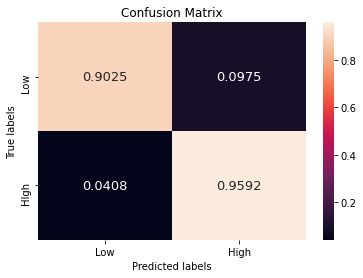

Precision: 0.9451  0.9267
Recall: 0.9025  0.9592
F1-Score 0.9233  0.9427
MCC 0.8667
AUROC 0.9309


In [39]:
report(test_labels, predictions_aln_gc.cpu().numpy())

### Aln-GC-MFE model

In [41]:
tr, vl, ts, cols = get_scaled_abl(['Aln', 'GC1', 'GC2', 'SingleMFE1', 'SingleMFE2'])

In [48]:
model_aln_gc_mfe = LightningWrapper()

In [49]:
early_stopping_aln_gc_mfe = EarlyStopping('val_loss', patience=3)

In [50]:
trainer_aln_gc_mfe = pl.Trainer(
    gpus=[0],
    callbacks=[early_stopping_aln_gc_mfe],
    min_epochs=3
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [51]:
trainer_aln_gc_mfe.fit(model_aln_gc_mfe)


  | Name | Type       | Params
------------------------------------
0 | lin  | Sequential | 3.1 K 
------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [52]:
trainer_aln_gc_mfe.test()

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.3977, device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_loss': 0.39765822887420654}]

In [53]:
predictions_aln_gc_mfe = torch.sigmoid(torch.cat(model_aln_gc_mfe.out_predictions))
predictions_aln_gc_mfe = torch.gt(predictions_aln_gc_mfe, 0.5).int()

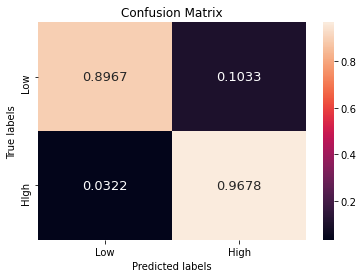

Precision: 0.9559  0.9233
Recall: 0.8967  0.9678
F1-Score 0.9254  0.9450
MCC 0.8718
AUROC 0.9323


In [54]:
report(test_labels, predictions_aln_gc_mfe.cpu().numpy())